In [223]:
from google.colab import drive
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt
import gdown
import math
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error
# feature processing libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
#LSTM model libaries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
#Exponential Smoothing Libaries
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
pd.options.display.float_format = '{:.2f}'.format

In [2]:
drive.mount('/content/drive')
df=pd.read_csv('/content/drive/MyDrive/Dataset/RBI_old_formatx.csv')
df.head()

Mounted at /content/drive


,Month_Year,Real_Time_Gross_Settlement_Volume,Real_Time_Gross_Settlement_Value,Retail_Electronic_Clearing_Volume,Retail_Electronic_Clearing_Value,Mobile_Banking_Volume,Mobile_Banking_Value,POS_Debit_Cards_Volume,POS_Debit_Cards_Value,POS_Credit_card_Volume,POS_Credit_card_Value
0,Oct-19,128.92,13861415.20,8399.74,2274304.97,12418.01,532759.21,4550.01,70125.60,2027.63,71138.73
1,Sep-19,114.42,14298230.40,7091.97,2140620.91,10980.26,470168.16,4149.34,55718.29,1794.71,59453.13
2,Aug-19,118.79,14842137.70,7299.24,2136862.52,10072.43,328042.98,4293.19,58077.58,1795.73,59600.59
3,Jul-19,127.45,16004194.30,6887.21,2114124.47,9175.84,533846.15,4256.41,58545.07,1784.16,59616.39
4,Jun-19,118.26,15299131.40,6436.48,2058081.45,8486.06,497543.06,4121.35,57453.29,1632.33,56928.42


In [3]:
df.shape

(187, 11)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 187 entries, 0 to 186
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Month_Year                         187 non-null    object 
 1   Real_Time_Gross_Settlement_Volume  187 non-null    float64
 2   Real_Time_Gross_Settlement_Value   187 non-null    float64
 3   Retail_Electronic_Clearing_Volume  187 non-null    float64
 4   Retail_Electronic_Clearing_Value   187 non-null    float64
 5   Mobile_Banking_Volume              103 non-null    float64
 6   Mobile_Banking_Value               103 non-null    float64
 7   POS_Debit_Cards_Volume             187 non-null    float64
 8   POS_Debit_Cards_Value              187 non-null    float64
 9   POS_Credit_card_Volume             187 non-null    float64
 10  POS_Credit_card_Value              187 non-null    float64
dtypes: float64(10), object(1)
memory usage: 16.2+ KB


### Preprocessing of Dataset

In [5]:
df.isnull().sum()

Month_Year                            0
Real_Time_Gross_Settlement_Volume     0
Real_Time_Gross_Settlement_Value      0
Retail_Electronic_Clearing_Volume     0
Retail_Electronic_Clearing_Value      0
Mobile_Banking_Volume                84
Mobile_Banking_Value                 84
POS_Debit_Cards_Volume                0
POS_Debit_Cards_Value                 0
POS_Credit_card_Volume                0
POS_Credit_card_Value                 0
dtype: int64

In [6]:
df.fillna(0, inplace=True) # replacing null values

In [7]:
df['Date'] = pd.to_datetime("01-" + df['Month_Year'], format="%d-%b-%y")
df = df.sort_values(by='Date')

In [ ]:
#creating dataset and scaling Value columns from Crores to billion, and scaling Value columns from Lakhs to Million

In [ ]:
df.columns

In [8]:
df_f= df[(df['Date'] >= '2014-03-01') & (df['Date'] <= '2019-10-31')]
df_f.Date.min(),df_f.Date.max()
df_f.shape

(68, 12)

In [9]:
# value columns in billion
value_columns = df_f[['Real_Time_Gross_Settlement_Value',
                 'Retail_Electronic_Clearing_Value',
                 'Mobile_Banking_Value',
                 'POS_Debit_Cards_Value',
                 'POS_Credit_card_Value']]
scaling_factor = 1 / 100  # Scaling from crores to billion
scaled_val = pd.DataFrame()
scaled_val['Date'] = df_f['Date']
for column in value_columns.columns:
    new_column_name = f'{column}'
    scaled_val[new_column_name] = value_columns[column].astype(float) * scaling_factor
# print(scaled_val)

In [10]:
# Volumn in million
volume_columns = df_f[['Real_Time_Gross_Settlement_Volume',
                       'Retail_Electronic_Clearing_Volume',
                       'Mobile_Banking_Volume',
                       'POS_Debit_Cards_Volume',
                       'POS_Credit_card_Volume']]
volume_columns_millions = volume_columns / 10
scaled_vol = pd.DataFrame()
scaled_vol['Date'] = df_f['Date']
scaled_vol = pd.concat([scaled_vol, volume_columns_millions], axis=1)

In [12]:
scaled_val.head(2)

,Date,Real_Time_Gross_Settlement_Value,Retail_Electronic_Clearing_Value,Mobile_Banking_Value,POS_Debit_Cards_Value,POS_Credit_card_Value
67,2014-03-01,99245.04,5728.81,33.91,85.77,145.49
66,2014-04-01,71295.24,4645.76,32.96,86.85,145.77


In [13]:
scaled_vol.head(2)

,Date,Real_Time_Gross_Settlement_Volume,Retail_Electronic_Clearing_Volume,Mobile_Banking_Volume,POS_Debit_Cards_Volume,POS_Credit_card_Volume
67,2014-03-01,8.64,122.36,10.74,56.98,46.11
66,2014-04-01,7.27,107.22,10.17,56.27,46.44


### Exploratory Data Analysis

In [14]:
df_vol_melted = pd.melt(scaled_vol, id_vars=['Date'], var_name='Mode', value_name='Volume')
df_val_melted = pd.melt(scaled_val, id_vars=['Date'], var_name='Mode', value_name='Value')
df_vol_melted.shape,df_val_melted.shape

((340, 3), (340, 3))

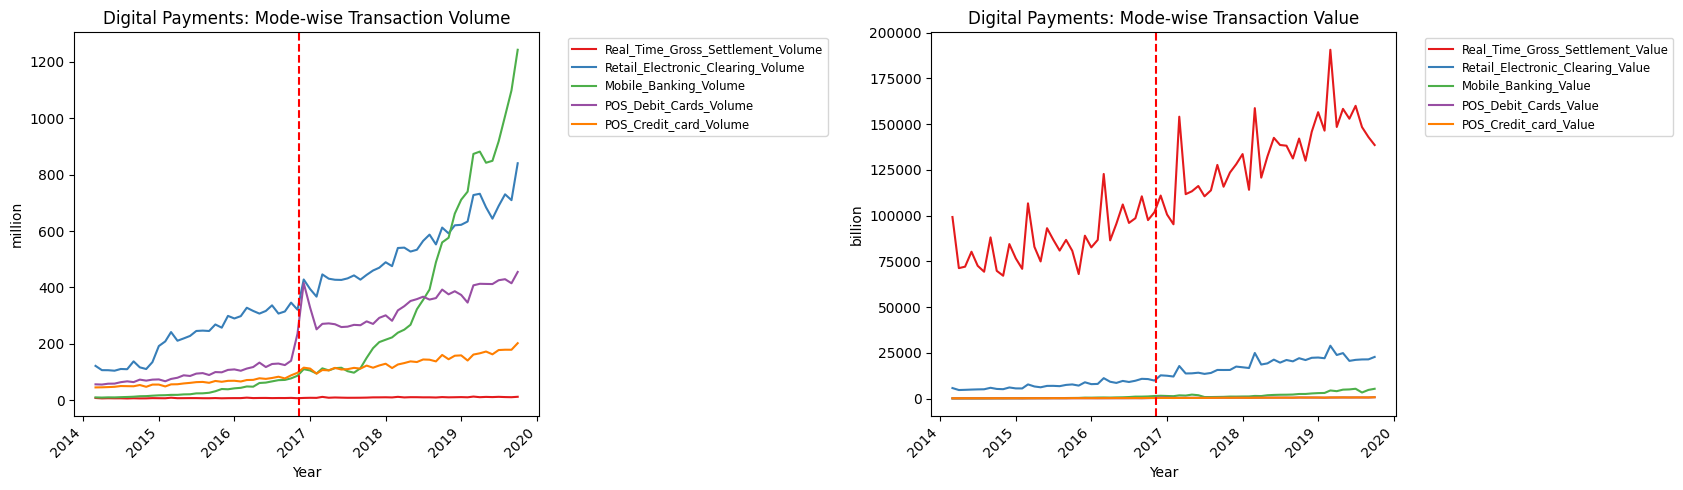

In [17]:
plt.figure(figsize=(17, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_vol_melted, x='Date', y='Volume', hue='Mode', palette='Set1', legend='full')
plt.title('Digital Payments: Mode-wise Transaction Volume')
plt.xlabel('Year')
plt.ylabel('million')
plt.axvline(pd.to_datetime("08-11-2016", format="%d-%m-%Y"), color='#FF0000', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adjust the legend box size

# Plot 2: Transaction Value
plt.subplot(1, 2, 2)
sns.lineplot(data=df_val_melted, x='Date', y='Value', hue='Mode', palette='Set1', legend='full')
plt.title('Digital Payments: Mode-wise Transaction Value')
plt.xlabel('Year')
plt.ylabel('billion')
plt.axvline(pd.to_datetime("08-11-2016", format="%d-%m-%Y"), color='#FF0000', linestyle='--')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')  # Adjust the legend box size

plt.tight_layout()
plt.show()

In [19]:
merged_df = pd.merge(scaled_vol, scaled_val, on='Date', how='inner')
merged_df.shape

(68, 11)

In [20]:
merged_df['Date'].min(),merged_df['Date'].max()

(Timestamp('2014-03-01 00:00:00'), Timestamp('2019-10-01 00:00:00'))

In [22]:
pre_demonetisation_data = merged_df[(merged_df['Date'] >= '2014-03-01') & (merged_df['Date'] <= '2016-11-01')]
post_demonetisation_data = merged_df[(merged_df['Date'] >= '2016-12-01') & (merged_df['Date'] <= '2019-10-01')]

In [23]:
def calculate_statistics(pre_data, post_data, volume_column, value_column):
    # Calculate statistics for the pre-demonetisation period
    min_volume_pre = pre_data[volume_column].min()
    max_volume_pre = pre_data[volume_column].max()
    mean_volume_pre = pre_data[volume_column].mean()

    min_value_pre = pre_data[value_column].min()
    max_value_pre = pre_data[value_column].max()
    mean_value_pre = pre_data[value_column].mean()

    # Calculate statistics for the post-demonetisation period
    min_volume_post = post_data[volume_column].min()
    max_volume_post = post_data[volume_column].max()
    mean_volume_post = post_data[volume_column].mean()

    min_value_post = post_data[value_column].min()
    max_value_post = post_data[value_column].max()
    mean_value_post = post_data[value_column].mean()

    # Create a DataFrame with the calculated statistics
    statistics = pd.DataFrame({
        'Statistic': ['Min', 'Max', 'Mean', 'Min', 'Max', 'Mean'],
        f'{volume_column}': [min_volume_pre, max_volume_pre, mean_volume_pre, min_volume_post, max_volume_post, mean_volume_post],
        f'{value_column}': [min_value_pre, max_value_pre, mean_value_pre, min_value_post, max_value_post, mean_value_post],
        'Period': ['Pre-Demonetisation'] * 3 + ['Post-Demonetisation'] * 3
    })

    return statistics

In [24]:
def plot_statistics_bar(statistics, volume_column, value_column, unit_volume, unit_value):
    sns.set(style="whitegrid")

    # Create a bar plot for Volume
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.barplot(x='Statistic', y=volume_column, hue='Period', data=statistics, palette='viridis')
    plt.title(f'{volume_column} - Pre vs Post Demonetisation')
    plt.ylabel(f'{unit_volume}')

    # Display values on top of bars
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                           xytext=(0, 10), textcoords='offset points', fontsize=8)

    # Create a bar plot for Value
    plt.subplot(1, 2, 2)
    sns.barplot(x='Statistic', y=value_column, hue='Period', data=statistics, palette='viridis')
    plt.title(f'{value_column} - Pre vs Post Demonetisation')
    plt.ylabel(f'{unit_value}')

    # Display values on top of bars
    for p in plt.gca().patches:
        plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center',
                           xytext=(0, 10), textcoords='offset points', fontsize=8)

    plt.tight_layout()
    plt.show()

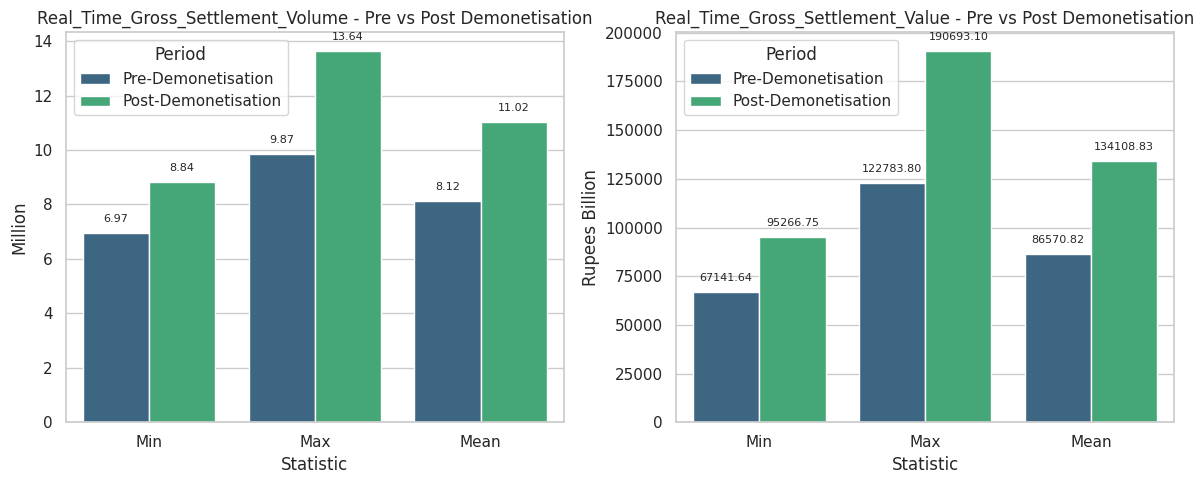

In [25]:
statistics_data = calculate_statistics(pre_demonetisation_data, post_demonetisation_data, 'Real_Time_Gross_Settlement_Volume', 'Real_Time_Gross_Settlement_Value')
plot_statistics_bar(statistics_data, 'Real_Time_Gross_Settlement_Volume', 'Real_Time_Gross_Settlement_Value', 'Million', 'Rupees Billion')

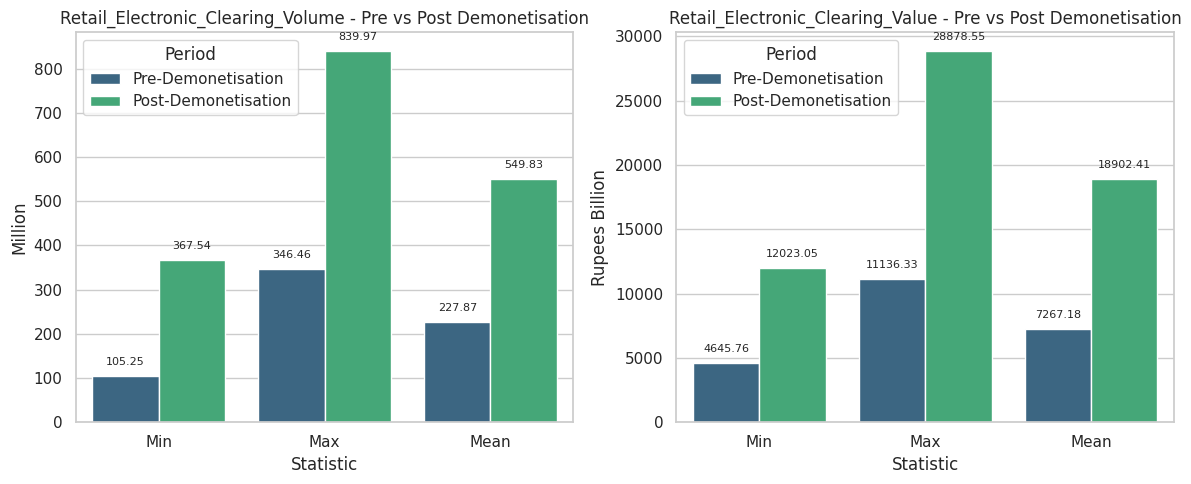

In [26]:
# Retai_Electronic_Clearing
statistics_data = calculate_statistics(pre_demonetisation_data, post_demonetisation_data, 'Retail_Electronic_Clearing_Volume', 'Retail_Electronic_Clearing_Value')
plot_statistics_bar(statistics_data, 'Retail_Electronic_Clearing_Volume', 'Retail_Electronic_Clearing_Value', 'Million', 'Rupees Billion')

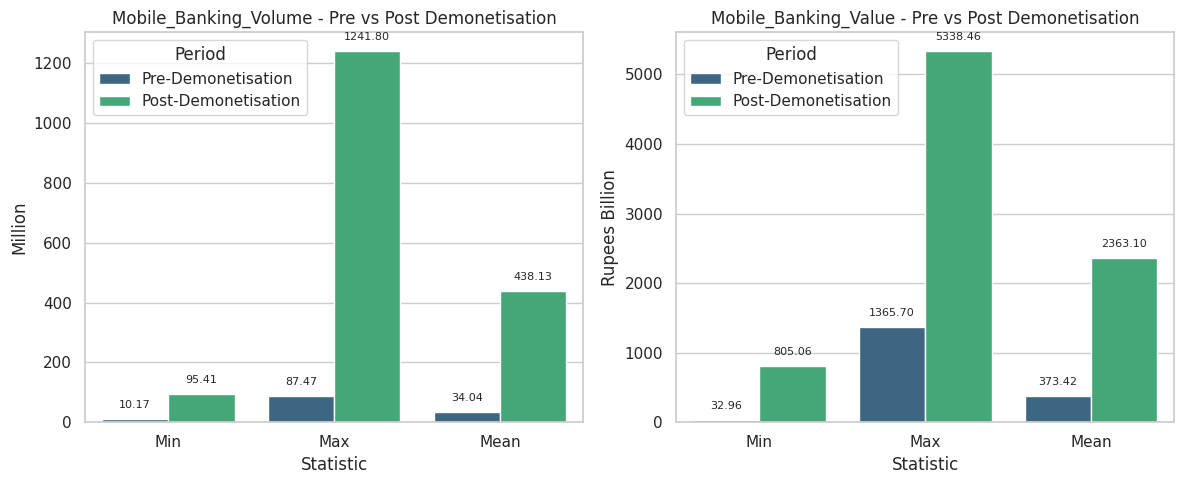

In [27]:
statistics_data = calculate_statistics(pre_demonetisation_data, post_demonetisation_data, 'Mobile_Banking_Volume', 'Mobile_Banking_Value')
plot_statistics_bar(statistics_data, 'Mobile_Banking_Volume', 'Mobile_Banking_Value', 'Million', 'Rupees Billion')

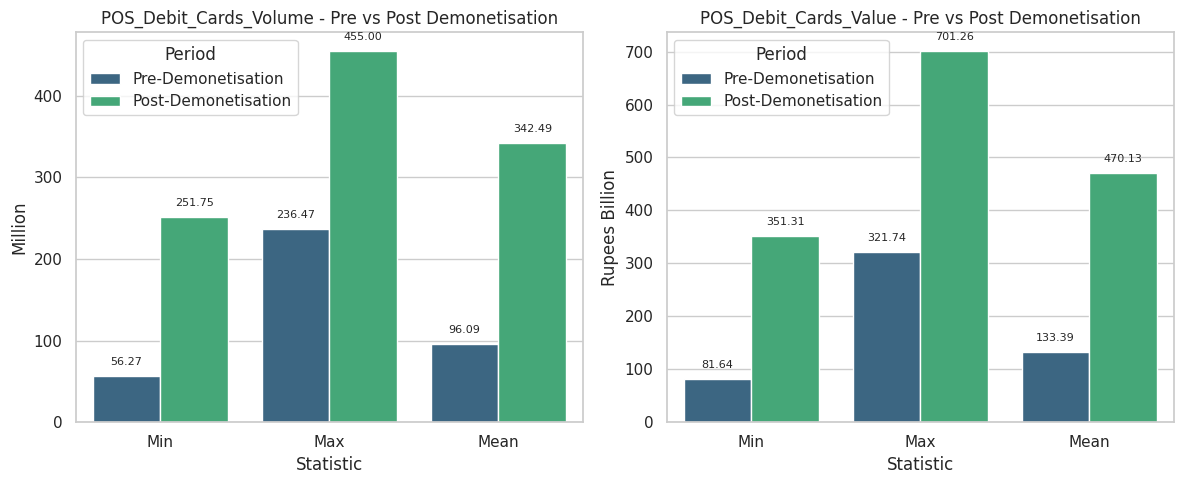

In [28]:
statistics_data = calculate_statistics(pre_demonetisation_data, post_demonetisation_data, 'POS_Debit_Cards_Volume', 'POS_Debit_Cards_Value')
plot_statistics_bar(statistics_data, 'POS_Debit_Cards_Volume', 'POS_Debit_Cards_Value', 'Million', 'Rupees Billion')

### Exponential Smoothing Model Implementation

Volume transaction  Columns

In [29]:
Volume_Metric_ES = pd.DataFrame(columns=['Column', 'Min_Test', 'Max_Test', 'MAE', 'RMSE', 'MSE'])
Value_Metric_ES = pd.DataFrame(columns=['Column', 'Min_Test', 'Max_Test', 'MAE', 'RMSE', 'MSE'])

In [44]:
scaled_vol.columns

Index(['Date', 'Real_Time_Gross_Settlement_Volume',
       'Retail_Electronic_Clearing_Volume', 'Mobile_Banking_Volume',
       'POS_Debit_Cards_Volume', 'POS_Credit_card_Volume'],
      dtype='object')

In [110]:
# need to update column name every time when we need to run the ES model for volume transaction columns
vol_column='POS_Credit_card_Volume'

In [111]:
def fit_exponential_smoothing_model(df, vol_column, test_size=0.2, seasonal_periods=12):
    # Extract relevant columns and set Date as index
    df = pd.DataFrame(df[['Date', vol_column]])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Split the data into train and test sets
    # train is from March 2014 to Aug 2018
    # test is from Sep 2018 to Oct 2019
    train, test = train_test_split(df, test_size=test_size, shuffle=False)

    # Fit the Exponential Smoothing model
    model_ses = ExponentialSmoothing(train[vol_column], trend="add", seasonal="add", seasonal_periods=seasonal_periods)
    model_ses = model_ses.fit()

    return model_ses, train, test

model_ses, train, test = fit_exponential_smoothing_model(scaled_vol, vol_column)
pred = model_ses.predict(start=test.index[0], end=test.index[-1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [85]:
def calculate_metrics_and_percentage(column_name, values, actual_values, predicted_values):
    metrics = {
        'Column': [column_name],
        'Min_Test': [np.min(values)],
        'Max_Test': [np.max(values)],
        'MAE': [mean_absolute_error(actual_values, predicted_values)],
        'RMSE': [np.sqrt(mean_squared_error(actual_values, predicted_values))],
        'MSE': [mean_squared_error(actual_values, predicted_values)]
    }

    mae_val = metrics['MAE'][0]
    rmse_val = metrics['RMSE'][0]
    mse_val = metrics['MSE'][0]

    # Calculate percentage metrics
    c = np.abs(metrics['Max_Test'][0] - metrics['Min_Test'][0]) / 2  # MAE
    mae_percentage = (mae_val / c) * 100

    a = np.sqrt(((metrics['Max_Test'][0] - metrics['Min_Test'][0]) ** 2) / 2)  # RMSE
    rmse_percentage = (rmse_val / a) * 100

    b = (((metrics['Max_Test'][0] - metrics['Min_Test'][0]) ** 2) / 2)  # MSE
    mse_percentage = (mse_val / b) * 100

    percentage_metrics = {
        'MAE Percentage': [mae_percentage],
        'RMSE Percentage': [rmse_percentage],
        'MSE Percentage': [mse_percentage]
    }

    metrics_df = pd.DataFrame(metrics)
    percentage_metrics_df = pd.DataFrame(percentage_metrics)

    return pd.concat([metrics_df, percentage_metrics_df], axis=1)

In [112]:
values = scaled_vol[vol_column]
actual_values = test[vol_column]
predicted_values = pred

Volume_Metric_ES = pd.concat([Volume_Metric_ES,calculate_metrics_and_percentage(vol_column, values, actual_values, predicted_values)], ignore_index=True)
Volume_Metric_ES

,Column,Min_Test,Max_Test,MAE,RMSE,MSE,MAE Percentage,RMSE Percentage,MSE Percentage
0,Retail_Electronic_Clearing_Volume,105.25,839.97,38.04,54.19,2936.41,10.35,10.43,1.09
1,Real_Time_Gross_Settlement_Volume,6.97,13.64,0.39,0.46,0.21,11.71,9.68,0.94
2,Mobile_Banking_Volume,10.17,1241.80,137.37,154.84,23975.16,22.31,17.78,3.16
3,POS_Debit_Cards_Volume,56.27,455.00,17.81,24.90,619.77,8.93,8.83,0.78
4,POS_Credit_card_Volume,46.11,202.76,9.04,11.91,141.90,11.54,10.75,1.16


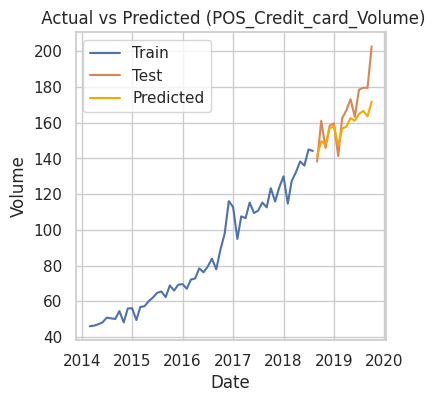

In [113]:
plt.figure(figsize=(4, 4))
plt.plot(train.index, train[vol_column], label='Train')
plt.plot(test.index, test[vol_column], label='Test')
plt.plot(test.index, pred, label='Predicted', color='orange')

plt.title(f' Actual vs Predicted ({vol_column})')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### Value transaction  Columns


In [114]:
scaled_val.columns

Index(['Date', 'Real_Time_Gross_Settlement_Value',
       'Retail_Electronic_Clearing_Value', 'Mobile_Banking_Value',
       'POS_Debit_Cards_Value', 'POS_Credit_card_Value'],
      dtype='object')

In [133]:
# need to update column name every time following Functions for Value transaction columns
val_column='POS_Credit_card_Value'

In [134]:
def fit_exponential_smoothing_model(df, vol_column, test_size=0.2, seasonal_periods=12):
    # Extract relevant columns and set Date as index
    df = pd.DataFrame(df[['Date', val_column]])
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)

    # Split the data into train and test sets
    # train is from March 2014 to Aug 2018
    # test is from Sep 2018 to Oct 2019
    train, test = train_test_split(df, test_size=test_size, shuffle=False)

    # Fit the Exponential Smoothing model
    model_ses = ExponentialSmoothing(train[val_column], trend="add", seasonal="add", seasonal_periods=seasonal_periods)
    model_ses = model_ses.fit()

    return model_ses, train, test

model_ses, train, test = fit_exponential_smoothing_model(scaled_val, val_column)
pred = model_ses.predict(start=test.index[0], end=test.index[-1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [135]:
values = scaled_val[val_column]
actual_values = test[val_column]
predicted_values = pred

Value_Metric_ES = pd.concat([Value_Metric_ES,calculate_metrics_and_percentage(val_column, values, actual_values, predicted_values)], ignore_index=True)
Value_Metric_ES

,Column,Min_Test,Max_Test,MAE,RMSE,MSE,MAE Percentage,RMSE Percentage,MSE Percentage
0,Real_Time_Gross_Settlement_Value,67141.64,190693.10,9278.91,11334.85,128478847.81,15.02,12.97,1.68
1,Retail_Electronic_Clearing_Value,4645.76,28878.55,3143.06,3995.58,15964620.91,25.94,23.32,5.44
2,Mobile_Banking_Value,32.96,5338.46,1186.42,1499.95,2249841.69,44.72,39.98,15.99
3,POS_Debit_Cards_Value,81.64,701.26,31.87,44.82,2008.46,10.29,10.23,1.05
4,POS_Credit_card_Value,145.49,711.39,19.28,24.90,619.88,6.81,6.22,0.39


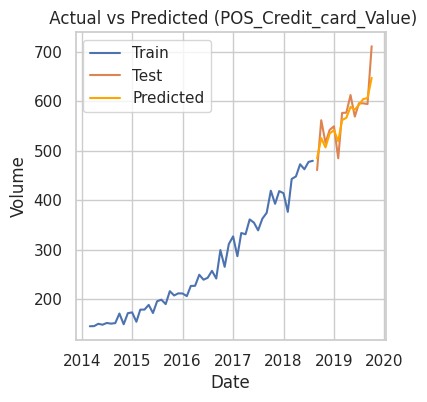

In [136]:
plt.figure(figsize=(4, 4))
plt.plot(train.index, train[vol_column], label='Train')
plt.plot(test.index, test[vol_column], label='Test')
plt.plot(test.index, pred, label='Predicted', color='orange')

plt.title(f' Actual vs Predicted ({vol_column})')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

### **LSTM model Implementation**

### Volume Transaction Columns

In [244]:
# Volume_metric_LSTM = pd.DataFrame(columns=['Column', 'Min_Test', 'Max_Test', 'MAE', 'RMSE', 'MSE'])
# Value_metric_LSTM = pd.DataFrame(columns=['Column', 'Min_Test', 'Max_Test', 'MAE', 'RMSE', 'MSE'])

In [296]:
Volume_metric_LSTM = pd.DataFrame()
Value_metric_LSTM = pd.DataFrame()

In [139]:
scaled_vol.columns

Index(['Date', 'Real_Time_Gross_Settlement_Volume',
       'Retail_Electronic_Clearing_Volume', 'Mobile_Banking_Volume',
       'POS_Debit_Cards_Volume', 'POS_Credit_card_Volume'],
      dtype='object')

In [339]:
# need to update column name every time when we need to run the ES model for volume transaction columns
vol_column='Real_Time_Gross_Settlement_Volume'

In [340]:
df2=pd.DataFrame(scaled_vol[['Date',vol_column]])
df2.index = pd.to_datetime(df2['Date'])
df2.drop(['Date'],axis=1,inplace=True)
df2.shape

(68, 1)

In [341]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df2)

In [342]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

54 14


In [343]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [344]:
look_back = 12
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [345]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [325]:
checkpoint_path = "/content/drive/MyDrive/Dataset/model15.h5"
checkpoint = ModelCheckpoint(checkpoint_path, monitor='loss', verbose=1, save_best_only=True, mode='min')

In [293]:
model15 = Sequential()
model15.add(LSTM(100, input_shape=(1, look_back)))
model15.add(Dense(1))
model15.compile(loss='mean_squared_error', optimizer='adam')
history=model15.fit(trainX, trainY, epochs=100, batch_size=256, verbose=2,callbacks=[checkpoint])

Epoch 1/100

Epoch 1: loss improved from inf to 0.19222, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 2s - loss: 0.1922 - 2s/epoch - 2s/step
Epoch 2/100

Epoch 2: loss improved from 0.19222 to 0.17603, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1760 - 39ms/epoch - 39ms/step
Epoch 3/100

Epoch 3: loss improved from 0.17603 to 0.16060, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1606 - 37ms/epoch - 37ms/step
Epoch 4/100

Epoch 4: loss improved from 0.16060 to 0.14592, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1459 - 38ms/epoch - 38ms/step
Epoch 5/100

Epoch 5: loss improved from 0.14592 to 0.13200, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1320 - 41ms/epoch - 41ms/step
Epoch 6/100


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: loss improved from 0.13200 to 0.11885, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1189 - 43ms/epoch - 43ms/step
Epoch 7/100

Epoch 7: loss improved from 0.11885 to 0.10647, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.1065 - 42ms/epoch - 42ms/step
Epoch 8/100

Epoch 8: loss improved from 0.10647 to 0.09488, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.0949 - 41ms/epoch - 41ms/step
Epoch 9/100

Epoch 9: loss improved from 0.09488 to 0.08408, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.0841 - 45ms/epoch - 45ms/step
Epoch 10/100

Epoch 10: loss improved from 0.08408 to 0.07409, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.0741 - 41ms/epoch - 41ms/step
Epoch 11/100

Epoch 11: loss improved from 0.07409 to 0.06492, saving model to /content/drive/MyDrive/Dataset/model15.h5
1/1 - 0s - loss: 0.0649 - 43ms/epoch - 43ms/step


In [346]:
trainPredict = model15.predict(trainX)
testPredict = model15.predict(testX)

1/1 [==============================] - 0s 20ms/step


In [347]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [282]:
def calculate_test_metrics_lstm(testY, testPredict):
    # Calculate RMSE
    testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))

    # Calculate MSE
    testMSE = mean_squared_error(testY[0], testPredict[:, 0])

    # Calculate MAE
    testMAE = mean_absolute_error(testY[0], testPredict[:, 0])

    # Create a DataFrame for the test metrics
    test_metrics_df = pd.DataFrame({
        'Test Score RMSE': [testScore],
        'Test MSE': [testMSE],
        'Test MAE': [testMAE]
    })

    return test_metrics_df

def calculate_percentage_metrics_lstm(min_val, max_val, mae, rmse, mse):
    c = np.abs(max_val - min_val) / 2  # MAE
    mae_percentage = (mae / c) * 100

    a = np.sqrt(((max_val - min_val) ** 2) / 2)  # RMSE
    rmse_percentage = (rmse / a) * 100

    b = (((max_val - min_val) ** 2) / 2)  # MSE
    mse_percentage = (mse / b) * 100

    return mae_percentage, rmse_percentage, mse_percentage

def calculate_and_store_percentage_metrics(column_name, scaled_vol, vol_column, testY, testPredict):
    # Calculate test metrics
    test_metrics_df = calculate_test_metrics_lstm(testY, testPredict)

    # Extract numeric values from the DataFrame
    min_val = scaled_vol[vol_column].min()
    max_val = scaled_vol[vol_column].max()
    mae_val = test_metrics_df['Test MAE'].values[0]
    rmse_val = test_metrics_df['Test Score RMSE'].values[0]
    mse_val = test_metrics_df['Test MSE'].values[0]

    # Calculate percentage metrics
    mae_per, rmse_per, mse_per = calculate_percentage_metrics_lstm(min_val, max_val, mae_val, rmse_val, mse_val)

    # Create a DataFrame for all metrics
    all_metrics_df = pd.DataFrame({
        'Column': [column_name],
        'Min_Test': [min_val],
        'Max_Test': [max_val],
        'Test Score RMSE': [test_metrics_df['Test Score RMSE'].values[0]],
        'Test MSE': [test_metrics_df['Test MSE'].values[0]],
        'Test MAE': [test_metrics_df['Test MAE'].values[0]],
        'MAE Percentage': [mae_per],
        'RMSE Percentage': [rmse_per],
        'MSE Percentage': [mse_per]
    })

    return all_metrics_df

In [354]:
Value_metric_LSTM = pd.concat([Value_metric_LSTM,calculate_and_store_percentage_metrics(vol_column, scaled_vol, vol_column, testY, testPredict)], ignore_index=True)
# Value_Metric_ES = pd.concat([Value_Metric_ES,calculate_metrics_and_percentage(val_column, values, actual_values, predicted_values)], ignore_index=True)
Value_metric_LSTM

,Column,Min_Test,Max_Test,Test Score RMSE,Test MSE,Test MAE,MAE Percentage,RMSE Percentage,MSE Percentage
0,Retail_Electronic_Clearing_Volume,105.25,839.97,18.51,342.49,18.51,5.04,3.56,0.13
1,POS_Debit_Cards_Volume,56.27,455.00,21.67,469.50,21.67,10.87,7.69,0.59
2,Mobile_Banking_Volume,10.17,1241.80,187.76,35252.76,187.76,30.49,21.56,4.65
3,POS_Credit_card_Volume,46.11,202.76,1.61,2.61,1.61,2.06,1.46,0.02
4,Real_Time_Gross_Settlement_Volume,6.97,13.64,0.98,0.96,0.98,29.42,20.80,4.33
5,Real_Time_Gross_Settlement_Volume,6.97,13.64,0.98,0.96,0.98,29.42,20.80,4.33


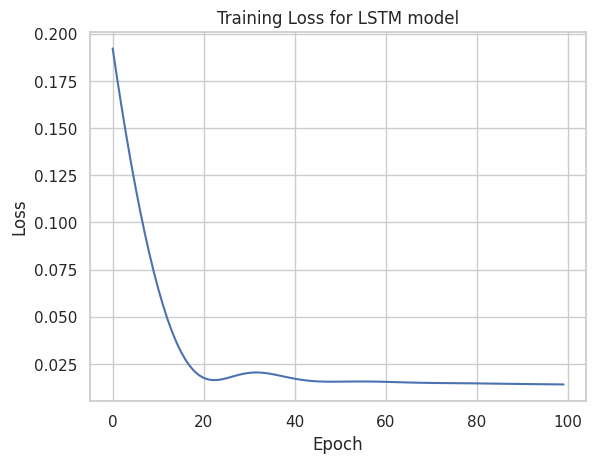

In [420]:
plt.plot(history.history['loss'])
plt.title('Training Loss for LSTM model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Value transaction Columns

In [355]:
scaled_val.columns

Index(['Date', 'Real_Time_Gross_Settlement_Value',
       'Retail_Electronic_Clearing_Value', 'Mobile_Banking_Value',
       'POS_Debit_Cards_Value', 'POS_Credit_card_Value'],
      dtype='object')

In [401]:
# need to update column name every time when we need to run the ES model for Value transaction columns
val_column='POS_Credit_card_Value'

In [402]:
df2=pd.DataFrame(scaled_val[['Date',val_column]])
df2.index = pd.to_datetime(df2['Date'])
df2.drop(['Date'],axis=1,inplace=True)
df2.shape

(68, 1)

In [403]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(df2)

In [404]:
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
print(len(train), len(test))

54 14


In [405]:
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-1):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [406]:
look_back = 12
trainX, trainY = create_dataset(train, look_back=look_back)
testX, testY = create_dataset(test, look_back=look_back)

In [407]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [408]:
trainPredict = model15.predict(trainX)
testPredict = model15.predict(testX)

1/1 [==============================] - 0s 20ms/step


In [409]:
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [410]:
Value_metric_LSTM = pd.concat([Value_metric_LSTM,calculate_and_store_percentage_metrics(val_column, scaled_val, val_column, testY, testPredict)], ignore_index=True)
# Value_Metric_ES = pd.concat([Value_Metric_ES,calculate_metrics_and_percentage(val_column, values, actual_values, predicted_values)], ignore_index=True)
Value_metric_LSTM

,Column,Min_Test,Max_Test,Test Score RMSE,Test MSE,Test MAE,MAE Percentage,RMSE Percentage,MSE Percentage
0,Real_Time_Gross_Settlement_Value,67141.64,190693.10,19482.29,379559613.90,19482.29,31.54,22.30,4.97
1,Retail_Electronic_Clearing_Value,4645.76,28878.55,2984.76,8908790.17,2984.76,24.63,17.42,3.03
2,Mobile_Banking_Value,32.96,5338.46,523.54,274093.67,523.54,19.74,13.96,1.95
3,POS_Debit_Cards_Value,81.64,701.26,44.65,1993.49,44.65,14.41,10.19,1.04
4,POS_Credit_card_Value,145.49,711.39,17.18,295.12,17.18,6.07,4.29,0.18
